In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import ppscore as pps
import statsmodels.api as sm

warnings.simplefilter("ignore")
%matplotlib inline

Steps: 
- Natural Log Normalize House Price -> then turn back after prediction
- Combine temporal variables (remove garage as it can be detected from hasGarage)
- Missing Values -> Fill with Missing, except for PoolQC, Alley etc change to binary
- Categorical to dummy variables

In [153]:
train = pd.read_csv("../data/train.csv", index_col = [0])
test = pd.read_csv("../data/test.csv", index_col = [0])

In [141]:
temporal = [var for var in train.columns if ("Yr" in var) 
        or ("Mo" in var) or ("Year" in var)]

levels = ["OverallCond", "OverallQual", "MSSubClass", "BsmtFullBath", 
            "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", 
            "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
            "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
            "BsmtExposure", "HeatingQC", "KitchenQual", 
          "GarageQual","GarageCond"]

categorical = [var for var in train.columns if (train[var].dtype =='O') 
               and (var not in temporal)
              and (var not in levels)]

numerical = [var for var in train.columns if (train[var].dtype !='O') 
             and (var not in temporal) 
             and (var not in levels)]
numerical_level = levels + numerical

In [142]:
## categorical to levels conversion
train["ExterQual"] = train["ExterQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["ExterCond"] = train["ExterCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtQual"] = train["BsmtQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtCond"] = train["BsmtCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtExposure"] = train["BsmtExposure"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["HeatingQC"] = train["HeatingQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["KitchenQual"] = train["KitchenQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageQual"] = train["GarageQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageCond"] = train["GarageCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

## Normalize Sale Price

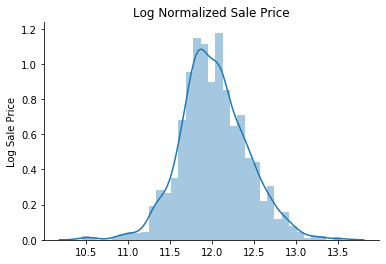

In [143]:
y_label = np.log(train[["SalePrice"]])

sns.distplot(y_label)
plt.title("Log Normalized Sale Price")
plt.ylabel("Log Sale Price")
sns.despine()
plt.show()

## Combine Temporal

In [144]:
temporal_train = pd.DataFrame()

In [145]:
temporal_train["n_temp_houseAge"] = \
    train["YrSold"] - train["YearBuilt"]
temporal_train["n_temp_lastRemodelled"] = \
    train["YrSold"] - train["YearRemodAdd"]

## Missing Values

In [146]:
numerical_train = train[numerical].fillna(0)
levels_train = train[levels].fillna(0)

In [147]:
categorical_train = train[categorical].copy()
cat1 = ["Alley", "MasVnrType", "BsmtFinType1", "BsmtFinType2", 
        "FireplaceQu", "GarageType", "GarageFinish", 
        "PoolQC", "Fence", "MiscFeature"]
categorical_train[cat1] = categorical_train[cat1].fillna("Missing")
categorical_train["Electrical"] = categorical_train["Electrical"].fillna(
    categorical_train["Electrical"].mode().iloc[0])

## Dummy Categorical Variables

In [129]:
dummy_categorical_train = pd.get_dummies(categorical_train, drop_first= True)

## Combining Everything

In [197]:
def shape_data(train):
    temporal = [var for var in train.columns if ("Yr" in var) 
            or ("Mo" in var) or ("Year" in var)]

    levels = ["OverallCond", "OverallQual", "MSSubClass", "BsmtFullBath", 
              "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", 
              "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
            "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC",
             "KitchenQual", "GarageQual", "GarageCond"]

    categorical = [var for var in train.columns if (train[var].dtype =='O') 
                   and (var not in temporal)
                  and (var not in levels)]

    numerical = [var for var in train.columns if (train[var].dtype !='O') 
                 and (var not in temporal) 
                 and (var not in levels)]
    numerical_level = levels + numerical
    
    ## categorical to levels conversion
    train["ExterQual"] = train["ExterQual"].map({"None":0,"Po":1, 
                                                 "Fa":2, "TA":3, 
                                                 "Gd":4, "Ex":5})
    train["ExterCond"] = train["ExterCond"].map({"None":0,"Po":1, 
                                                 "Fa":2, "TA":3, 
                                                 "Gd":4, "Ex":5})
    train["BsmtQual"] = train["BsmtQual"].map({"None":0,"Po":1, 
                                               "Fa":2, "TA":3, 
                                               "Gd":4, "Ex":5})
    train["BsmtCond"] = train["BsmtCond"].map({"None":0,"Po":1, 
                                               "Fa":2, "TA":3, 
                                               "Gd":4, "Ex":5})
    train["BsmtExposure"] = train["BsmtExposure"].map({"None":0,"Po":1, 
                                                       "Fa":2, "TA":3, 
                                                       "Gd":4, "Ex":5})
    train["HeatingQC"] = train["HeatingQC"].map({"None":0,"Po":1, 
                                                 "Fa":2, "TA":3, 
                                                 "Gd":4, "Ex":5})
    train["KitchenQual"] = train["KitchenQual"].map({"None":0,"Po":1, 
                                                     "Fa":2, "TA":3, 
                                                     "Gd":4, "Ex":5})
    train["GarageQual"] = train["GarageQual"].map({"None":0,"Po":1, 
                                                   "Fa":2, "TA":3, 
                                                   "Gd":4, "Ex":5})
    train["GarageCond"] = train["GarageCond"].map({"None":0,"Po":1, 
                                                   "Fa":2, "TA":3, 
                                                   "Gd":4, "Ex":5})
    ## label
    try:
        label_train = pd.DataFrame()
        label_train["log_SalePrice"] = np.log(train["SalePrice"])
        label_train["SalePrice"] = train["SalePrice"]
    except:
        pass
    
    ## temporal data
    temporal_train = pd.DataFrame()
    temporal_train["n_temp_houseAge"] = \
        train["YrSold"] - train["YearBuilt"]
    temporal_train["n_temp_lastRemodelled"] = \
        train["YrSold"] - train["YearRemodAdd"]
    
    ## numerical data
    numerical_train = train[numerical].fillna(0)
    
    ## ranked data
    levels_train = train[levels].fillna(0)
    
    ## categorical data
    categorical_train = train[categorical].copy()
    cat1 = ["Alley", "MasVnrType", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", 
            "GarageType", "GarageFinish", "PoolQC", "Fence", "MiscFeature"]
    categorical_train[cat1] = categorical_train[cat1].fillna("Missing")
    categorical_train["Electrical"] = categorical_train["Electrical"].fillna(
        categorical_train["Electrical"].mode().iloc[0])
    
    dummy_categorical_train = pd.get_dummies(categorical_train, drop_first= True)
    
    train_results = pd.concat([temporal_train, 
                               numerical_train.drop("SalePrice", axis = 1), 
                               levels_train, 
                               dummy_categorical_train, 
                               label_train], axis = 1)
    return train_results

In [198]:
train_results = shape_data(train)

# train_results, test_results = train_results.align(test_results, 
#                                                   join='outer', 
#                                                   axis=1, 
#                                                   fill_value="Missing")

In [199]:
train_results.to_csv("../data/feature_engineered_training_data.csv")
test_results.to_csv("../data/feature_engineered_test_data.csv")